<a href="https://colab.research.google.com/github/CodewithTanzeel/Student-Score-Prediction/blob/main/StudentScorePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Cell 1: Imports and settings
# Formal comments are included as requested.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
# Make plots show inline when using Jupyter/Colab
# (If running in a plain script this has no effect.)
# %matplotlib inline


# Reproducible results
RANDOM_STATE = 42

# Output folder for saved plots and results
OUT_DIR = 'student_score_outputs'
os.makedirs(OUT_DIR, exist_ok=True)

In [2]:
# Cell 2: Load dataset
# Configure your CSV path here. Replace if necessary.
DATA_PATH = 'student_scores.csv' # <-- change to your file path


# Load the CSV into a DataFrame and show basic info
try:
 df = pd.read_csv('/content/StudentPerformanceFactors.csv')
except FileNotFoundError:
 raise FileNotFoundError(f"Could not find the file at {"/content/StudentPerformanceFactors.csv"}. Please update DATA_PATH to your CSV's path.")


# Display basic info for quick inspection
print('Columns:', df.columns.tolist())
print('\nFirst 5 rows:')
print(df.head().to_string(index=False))
print('\nDataset info:')
df.info()
print('\nNumeric summary:')
print(df.describe().round(2))

Columns: ['Hours_Studied', 'Attendance', 'Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours', 'Previous_Scores', 'Motivation_Level', 'Internet_Access', 'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender', 'Exam_Score']

First 5 rows:
 Hours_Studied  Attendance Parental_Involvement Access_to_Resources Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level Internet_Access  Tutoring_Sessions Family_Income Teacher_Quality School_Type Peer_Influence  Physical_Activity Learning_Disabilities Parental_Education_Level Distance_from_Home Gender  Exam_Score
            23          84                  Low                High                         No            7               73              Low             Yes                  0           Low          Medium      Public       Positive             

In [3]:
# Preview dataset
print(df.head())


   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Internet_Access  Tutoring_Sessions Family_Income Teacher_Quality  \
0             Ye

In [4]:
# Step 3: Data Preprocessing
# Check for missing values
print("Missing values before:")
print(df.isnull().sum())



Missing values before:
Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64


In [5]:
# Drop rows with missing values (if any)
df = df.dropna()


In [6]:
# Check again
print("Missing values after:")
print(df.isnull().sum())


Missing values after:
Hours_Studied                 0
Attendance                    0
Parental_Involvement          0
Access_to_Resources           0
Extracurricular_Activities    0
Sleep_Hours                   0
Previous_Scores               0
Motivation_Level              0
Internet_Access               0
Tutoring_Sessions             0
Family_Income                 0
Teacher_Quality               0
School_Type                   0
Peer_Influence                0
Physical_Activity             0
Learning_Disabilities         0
Parental_Education_Level      0
Distance_from_Home            0
Gender                        0
Exam_Score                    0
dtype: int64


In [7]:
# Basic statistics
print(df[['Hours_Studied','Exam_Score']].describe())

       Hours_Studied   Exam_Score
count    6378.000000  6378.000000
mean       19.977109    67.252117
std         5.985460     3.914217
min         1.000000    55.000000
25%        16.000000    65.000000
50%        20.000000    67.000000
75%        24.000000    69.000000
max        44.000000   101.000000


In [8]:
# Outlier Removal using IQR (Interquartile Range)

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for Hours_studied and Exam_Score
Q1_hours = df['Hours_Studied'].quantile(0.25)
Q3_hours = df['Hours_Studied'].quantile(0.75)
IQR_hours = Q3_hours - Q1_hours

Q1_score = df['Exam_Score'].quantile(0.25)
Q3_score = df['Exam_Score'].quantile(0.75)
IQR_score = Q3_score - Q1_score

# Define bounds for Hours_studied
lower_bound_hours = Q1_hours - 1.5 * IQR_hours
upper_bound_hours = Q3_hours + 1.5 * IQR_hours

# Define bounds for Exam_Score
lower_bound_score = Q1_score - 1.5 * IQR_score
upper_bound_score = Q3_score + 1.5 * IQR_score

# Filter dataset (keep only rows within bounds)
df = df[
    (df['Hours_Studied'] >= lower_bound_hours) & (df['Hours_Studied'] <= upper_bound_hours) &
    (df['Exam_Score'] >= lower_bound_score) & (df['Exam_Score'] <= upper_bound_score)
]

print("Data after removing outliers:", df.shape)


Data after removing outliers: (6248, 20)


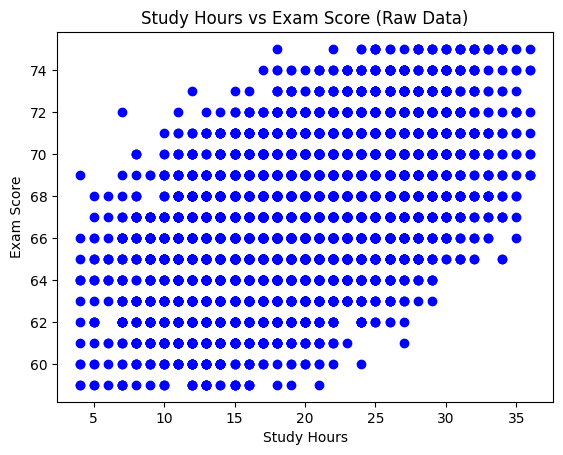

In [9]:
# Step 4: Exploratory Data Visualization
plt.scatter(df['Hours_Studied'], df['Exam_Score'], color="blue")
plt.xlabel("Study Hours")
plt.ylabel("Exam Score")
plt.title("Study Hours vs Exam Score (Raw Data)")
plt.show()

In [10]:
X = df[['Hours_Studied']] # Feature
y = df['Exam_Score'] # Target

In [11]:
# Step 6: Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [13]:
print("Regression Equation: Score = {:.2f} * Hours + {:.2f}".format(model.coef_[0], model.intercept_))

Regression Equation: Score = 0.28 * Hours + 61.53


In [14]:
# Step 8: Make predictions
y_pred = model.predict(X_test)

In [15]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("R² Score:", r2)

Mean Squared Error: 7.834989268338471
R² Score: 0.24712790979566512


In [29]:
# ----- Polynomial Regression (degree=2) -----
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
y_pred_poly = poly_reg.predict(X_test_poly)
oly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
y_pred_poly = poly_reg.predict(X_test_poly)


print("\nPolynomial Regression (Degree=2):")
print("  R²:", r2_score(y_test, y_pred_poly))
print("  RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_poly)))


Polynomial Regression (Degree=2):
  R²: 0.24735037493970202
  RMSE: 2.7986915010550035


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


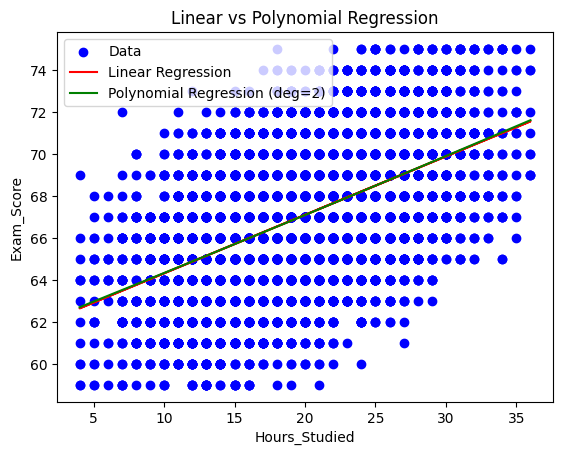

In [30]:
# ----- Visualization -----
plt.scatter(X, y, color="blue", label="Data")

# Linear line
plt.plot(X_test, y_pred, color="red", label="Linear Regression")

# Polynomial curve
X_grid = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
plt.plot(X_grid, poly_reg.predict(poly.transform(X_grid)),
         color="green", label="Polynomial Regression (deg=2)")

plt.xlabel("Hours_Studied")
plt.ylabel("Exam_Score")
plt.legend()
plt.title("Linear vs Polynomial Regression")
plt.show()

In [31]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score (Accuracy-like metric):", r2)


Mean Squared Error (MSE): 7.834989268338471
Root Mean Squared Error (RMSE): 2.7991050834755153
R² Score (Accuracy-like metric): 0.24712790979566512
